<a href="https://colab.research.google.com/github/mddsayemm/Data-Fusion-Cooperative-Perception/blob/main/CoopFusingSingle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install open3d matplotlib opencv-python scipy pandas shapely tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
import os
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd

import open3d as o3d
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

plt.rcParams["figure.figsize"] = (6, 6)


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# CHANGE THIS if your path is different
ROOT_DIR = "/content/drive/MyDrive/CoopFusion"

CALIB_DIR = os.path.join(ROOT_DIR, "calibration")
TRAIN_DIR = os.path.join(ROOT_DIR, "train")

IMG_DIR = os.path.join(TRAIN_DIR, "images")
PCD_DIR = os.path.join(TRAIN_DIR, "point_clouds")
LBL_DIR = os.path.join(TRAIN_DIR, "labels_point_clouds")

print("Root:", ROOT_DIR)
print("Calibration dir:", CALIB_DIR)
print("Train dir:", TRAIN_DIR)
print("="*80)

def count_files(path):
    total = 0
    for _, _, files in os.walk(path):
        total += len(files)
    return total

def list_folder_summary(path, name=""):
    print(f"\n📁 {name} = {path}")
    try:
        subs = os.listdir(path)
        print(f"  ├─ Contains {len(subs)} direct items")
        for item in subs:
            full_path = os.path.join(path, item)
            if os.path.isdir(full_path):
                num_files = count_files(full_path)
                print(f"    • {item}/  → {num_files} files total")
            else:
                print(f"    • {item} (file)")
    except Exception as e:
        print("  ERROR:", e)

list_folder_summary(CALIB_DIR, "Calibration")
list_folder_summary(IMG_DIR, "Images")
list_folder_summary(PCD_DIR, "Point Clouds")
list_folder_summary(LBL_DIR, "Labels")


Root: /content/drive/MyDrive/CoopFusion
Calibration dir: /content/drive/MyDrive/CoopFusion/calibration
Train dir: /content/drive/MyDrive/CoopFusion/train

📁 Calibration = /content/drive/MyDrive/CoopFusion/calibration
  ├─ Contains 8 direct items
    • s110_camera_basler_east_8mm.json (file)
    • s110_camera_basler_north_8mm.json (file)
    • s110_camera_basler_south1_8mm.json (file)
    • s110_camera_basler_south2_8mm.json (file)
    • s110_camera_basler_south1_8mm_R4.json (file)
    • vehicle_camera_basler_16mm.json (file)
    • s110_lidar_ouster_south.json (file)
    • vehicle_lidar_robosense.json (file)

📁 Images = /content/drive/MyDrive/CoopFusion/train/images
  ├─ Contains 5 direct items
    • vehicle_camera_basler_16mm/  → 1 files total
    • s110_camera_basler_south1_8mm/  → 1 files total
    • s110_camera_basler_south2_8mm/  → 1 files total
    • s110_camera_basler_east_8mm/  → 1 files total
    • s110_camera_basler_north_8mm/  → 1 files total

📁 Point Clouds = /content/drive/

In [15]:
# Names from your structure
FUSED_LIDAR_NAME = "s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered"

FUSED_PCD_DIR = os.path.join(PCD_DIR, FUSED_LIDAR_NAME)
FUSED_LBL_DIR = os.path.join(LBL_DIR, FUSED_LIDAR_NAME)

print("Fused PCD dir :", FUSED_PCD_DIR)
print("Fused Label dir:", FUSED_LBL_DIR)

# Find fused PCD file (01.pcd, case-insensitive)
fused_pcd_files = [f for f in os.listdir(FUSED_PCD_DIR)
                   if f.lower().endswith(".pcd")]
print("Fused PCD files:", fused_pcd_files)

if len(fused_pcd_files) == 0:
    raise RuntimeError("No .pcd file found in fused PCD dir. Check name (01.pcd).")

if len(fused_pcd_files) > 1:
    print("⚠️ More than one fused PCD file found, using the first one.")

fused_pcd_name = sorted(fused_pcd_files)[0]
fused_pcd_path = os.path.join(FUSED_PCD_DIR, fused_pcd_name)

print("Using fused PCD:", fused_pcd_path)

# Match label JSON by same base name "01"
base_name, _ = os.path.splitext(fused_pcd_name)

label_candidates = [f for f in os.listdir(FUSED_LBL_DIR)
                    if f.lower().endswith(".json")]
print("Label candidates:", label_candidates)

label_json_path = None
for lf in label_candidates:
    stem = os.path.splitext(lf)[0]
    if stem == base_name:
        label_json_path = os.path.join(FUSED_LBL_DIR, lf)
        break

print("Selected label JSON path:", label_json_path)


Fused PCD dir : /content/drive/MyDrive/CoopFusion/train/point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered
Fused Label dir: /content/drive/MyDrive/CoopFusion/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered
Fused PCD files: ['01.PCD']
Using fused PCD: /content/drive/MyDrive/CoopFusion/train/point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered/01.PCD
Label candidates: ['01.JSON']
Selected label JSON path: /content/drive/MyDrive/CoopFusion/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered/01.JSON


In [16]:
pcd_fused = o3d.io.read_point_cloud(fused_pcd_path)
fused_points = np.asarray(pcd_fused.points)

print("Fused LiDAR point cloud shape:", fused_points.shape)
print("First 5 points:\n", fused_points[:5])


Fused LiDAR point cloud shape: (98937, 3)
First 5 points:
 [[ 5.62437932e+00 -3.47036280e+00 -7.80735293e+00]
 [ 8.87539709e+01 -9.71294721e+00 -5.34774477e-03]
 [ 1.49699504e+01  2.37435702e+00 -4.19809407e+00]
 [ 1.48010995e+01  2.42933335e+00 -5.48394028e+00]
 [ 1.68802438e+01  3.80197021e-01 -5.65529642e+00]]


In [17]:
def make_bev_height_map(points,
                        x_range=(-60.0, 60.0),
                        y_range=(-60.0, 60.0),
                        resolution=0.2):
    x_min, x_max = x_range
    y_min, y_max = y_range

    x_bins = int((x_max - x_min) / resolution)
    y_bins = int((y_max - y_min) / resolution)

    bev = np.full((y_bins, x_bins), np.nan, dtype=np.float32)

    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]

    mask = (
        (xs >= x_min) & (xs < x_max) &
        (ys >= y_min) & (ys < y_max)
    )
    xs = xs[mask]
    ys = ys[mask]
    zs = zs[mask]

    ix = ((xs - x_min) / resolution).astype(int)
    iy = ((ys - y_min) / resolution).astype(int)

    for x_idx, y_idx, z in zip(ix, iy, zs):
        if np.isnan(bev[y_idx, x_idx]) or z > bev[y_idx, x_idx]:
            bev[y_idx, x_idx] = z

    return bev, x_range, y_range


In [18]:
bev_res = 0.2
bev_x_range = (-60.0, 60.0)
bev_y_range = (-60.0, 60.0)

bev_height, x_range, y_range = make_bev_height_map(
    fused_points,
    x_range=bev_x_range,
    y_range=bev_y_range,
    resolution=bev_res
)

print("Fused BEV shape:", bev_height.shape)


Fused BEV shape: (600, 600)


In [19]:
if label_json_path is None:
    print("⚠️ No label JSON found for fused LiDAR.")
else:
    print("Loading labels from:", label_json_path)
    with open(label_json_path, "r") as f:
        label_data = json.load(f)

    print("Top-level keys:", list(label_data.keys()))
    if "openlabel" in label_data:
        ol = label_data["openlabel"]
        print("Keys in 'openlabel':", list(ol.keys()))
        frames = ol.get("frames", {})
        print("Number of frames:", len(frames))
        print("Frame keys:", list(frames.keys())[:5])
    else:
        print("⚠️ 'openlabel' key not found.")


Loading labels from: /content/drive/MyDrive/CoopFusion/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered/01.JSON
Top-level keys: ['openlabel']
Keys in 'openlabel': ['metadata', 'coordinate_systems', 'frames']
Number of frames: 1
Frame keys: ['99']


In [20]:
def extract_boxes_from_openlabel(label_data):
    """
    Extract 3D bounding boxes (center, size, yaw, category)
    from OpenLABEL JSON with cuboid 'val' =
    [x, y, z, roll, pitch, sin(yaw), cos(yaw), length, width, height]
    """
    boxes = []

    if "openlabel" not in label_data:
        print("⚠️ No 'openlabel' in label JSON.")
        return boxes

    ol = label_data["openlabel"]
    frames = ol.get("frames", {})
    if not frames:
        print("⚠️ No 'frames' in 'openlabel'.")
        return boxes

    frame_key = sorted(frames.keys())[0]
    frame_data = frames[frame_key]
    print("Using frame key:", frame_key)

    objects = frame_data.get("objects", {})
    print("Number of objects:", len(objects))

    for obj_id, obj in objects.items():
        obj_data = obj.get("object_data", {})

        # Category: type or derived from name
        cat = obj_data.get("type", None)
        if cat is None:
            name = obj_data.get("name", "")
            if "_" in name:
                cat = name.split("_")[0]
            else:
                cat = name or None

        cub = obj_data.get("cuboid", None)
        if cub is None:
            continue

        if isinstance(cub, list):
            if not cub:
                continue
            cub = cub[0]

        vals = cub.get("val", None)
        if vals is None:
            continue

        vals = list(vals)
        if len(vals) < 10:
            print(f"⚠️ Object {obj_id} has cuboid 'val' shorter than 10:", vals)
            continue

        x, y, z = vals[0], vals[1], vals[2]
        # roll = vals[3]
        # pitch = vals[4]
        sin_yaw = vals[5]
        cos_yaw = vals[6]
        l, w, h = vals[7], vals[8], vals[9]

        yaw_rad = math.atan2(sin_yaw, cos_yaw)

        boxes.append({
            "id": obj_id,
            "category": cat,
            "center": (x, y, z),
            "size": (l, w, h),
            "yaw": yaw_rad,
        })

    return boxes

if label_json_path is not None:
    boxes = extract_boxes_from_openlabel(label_data)
    print("\nExtracted boxes:", len(boxes))
    if boxes:
        print("Example box:", boxes[0])
else:
    boxes = []


Using frame key: 99
Number of objects: 31

Extracted boxes: 31
Example box: {'id': 'ff39ed8c-8c9b-4a58-8899-2d737610b747', 'category': 'BUS', 'center': (17.707270049768294, 22.09080903738772, -6.101840019226074), 'size': (13.217904090881348, 3.2098560333251953, 3.7107508182525635), 'yaw': -0.8300000000000002}


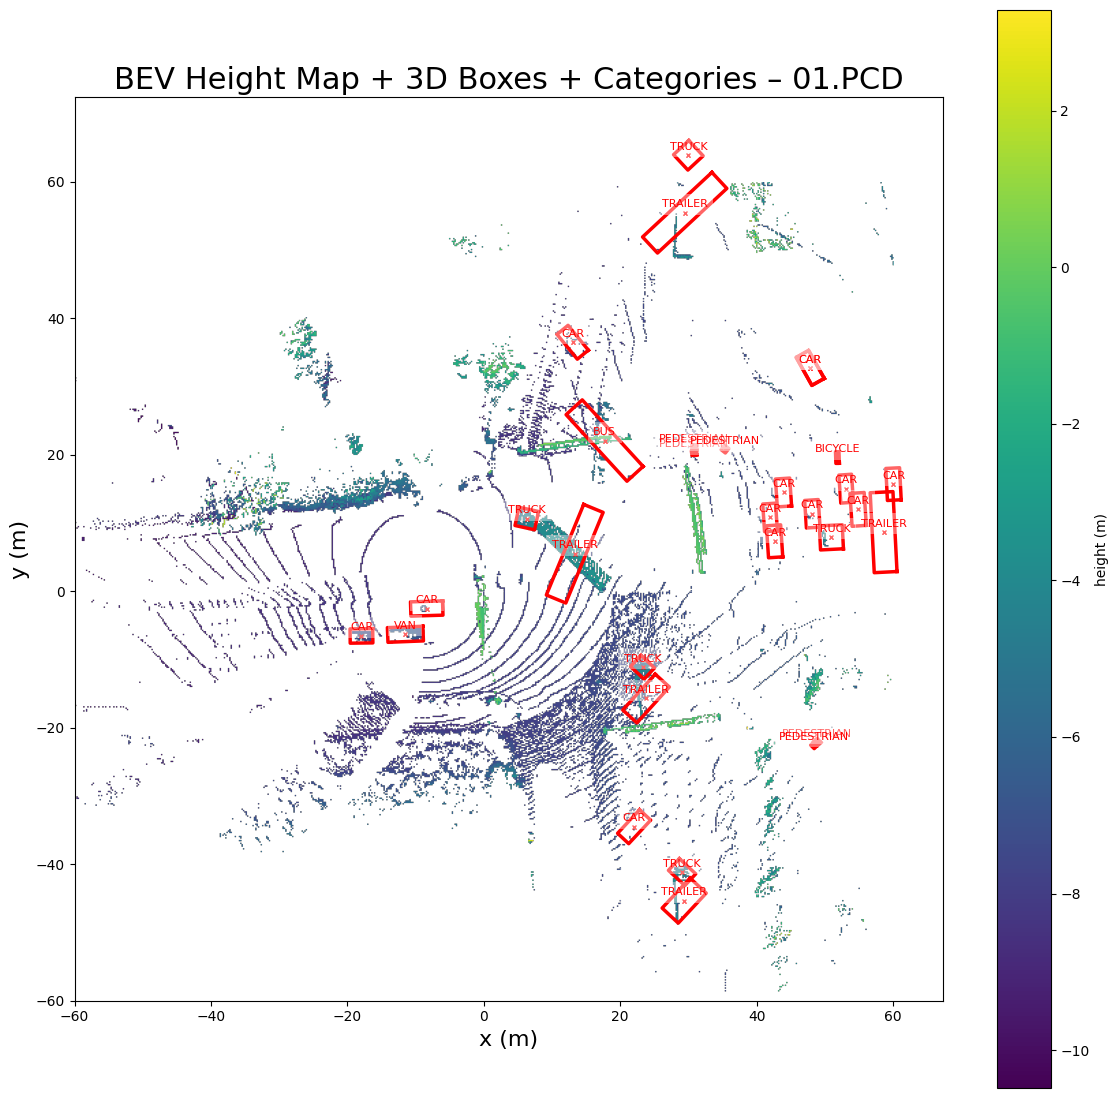

In [21]:
from math import cos, sin

def draw_boxes_on_bev(ax, boxes, x_range, y_range,
                      edge_color="red", linewidth=2.5, show_labels=True):
    x_min, x_max = x_range
    y_min, y_max = y_range

    for box in boxes:
        (cx, cy, cz) = box["center"]
        (l, w, h) = box["size"]
        yaw = box["yaw"]
        cat = box["category"]

        dx = l / 2.0
        dy = w / 2.0
        corners = np.array([
            [ dx,  dy],
            [ dx, -dy],
            [-dx, -dy],
            [-dx,  dy],
            [ dx,  dy],
        ])

        R = np.array([
            [ cos(yaw), -sin(yaw)],
            [ sin(yaw),  cos(yaw)]
        ])

        rotated = (R @ corners.T).T
        rotated[:, 0] += cx
        rotated[:, 1] += cy

        xs = rotated[:, 0]
        ys = rotated[:, 1]

        ax.plot(xs, ys, color=edge_color, linewidth=linewidth)
        ax.plot(cx, cy, marker="x", color=edge_color, markersize=3)

        if show_labels and cat is not None:
            ax.text(cx, cy + 0.5, str(cat),
                    color=edge_color, fontsize=8,
                    ha="center", va="bottom",
                    bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"))

plt.figure(figsize=(14, 14))
ax = plt.gca()

im = ax.imshow(
    bev_height,
    origin="lower",
    extent=(x_range[0], x_range[1], y_range[0], y_range[1])
)

plt.xlabel("x (m)", fontsize=16)
plt.ylabel("y (m)", fontsize=16)
plt.title(f"BEV Height Map + 3D Boxes + Categories – {fused_pcd_name}",
          fontsize=22)
plt.colorbar(im, label="height (m)")

if boxes:
    draw_boxes_on_bev(ax, boxes, x_range, y_range,
                      edge_color="red", linewidth=2.5, show_labels=True)
else:
    print("⚠️ No boxes to draw (boxes list is empty).")

ax.set_aspect("equal")
ax.grid(color='white', alpha=0.3, linestyle='--')

# Optional zoom:
# ax.set_xlim(-20, 40)
# ax.set_ylim(-20, 40)

plt.show()


In [38]:
# Roadside LiDAR
RS_LIDAR_NAME = "s110_lidar_ouster_south"
RS_LIDAR_DIR = os.path.join(PCD_DIR, RS_LIDAR_NAME)

rs_pcd_files = [f for f in os.listdir(RS_LIDAR_DIR)
                if f.lower().endswith(".pcd")]
print("Roadside LiDAR files:", rs_pcd_files)

rs_pcd_name = sorted(rs_pcd_files)[0]
rs_pcd_path = os.path.join(RS_LIDAR_DIR, rs_pcd_name)

rs_pcd = o3d.io.read_point_cloud(rs_pcd_path)
rs_points = np.asarray(rs_pcd.points)
print("Roadside points:", rs_points.shape)

# Vehicle LiDAR
VEH_LIDAR_NAME = "vehicle_lidar_robosense"
VEH_LIDAR_DIR = os.path.join(PCD_DIR, VEH_LIDAR_NAME)

veh_pcd_files = [f for f in os.listdir(VEH_LIDAR_DIR)
                 if f.lower().endswith(".pcd")]
print("Vehicle LiDAR files:", veh_pcd_files)

veh_pcd_name = sorted(veh_pcd_files)[0]
veh_pcd_path = os.path.join(VEH_LIDAR_DIR, veh_pcd_name)

veh_pcd = o3d.io.read_point_cloud(veh_pcd_path)
veh_points = np.asarray(veh_pcd.points)
print("Vehicle points:", veh_points.shape)

# BEVs
bev_rs, _, _    = make_bev_height_map(rs_points,
                                      x_range=bev_x_range,
                                      y_range=bev_y_range,
                                      resolution=bev_res)

bev_veh, _, _   = make_bev_height_map(veh_points,
                                      x_range=bev_x_range,
                                      y_range=bev_y_range,
                                      resolution=bev_res)

bev_fused, _, _ = make_bev_height_map(fused_points,
                                      x_range=bev_x_range,
                                      y_range=bev_y_range,
                                      resolution=bev_res)
# ===========================
# Vehicle camera BEV position
# ===========================
# These are example coordinates in BEV (meters) in the same frame as LiDAR/boxes.
# You will adjust these later when you know the exact values from calibration/docs.

VEH_LIDAR_X = 0.0
VEH_LIDAR_Y = 0.0


Roadside LiDAR files: ['01.pcd']
Roadside points: (131072, 3)
Vehicle LiDAR files: ['01.pcd']
Vehicle points: (57600, 3)


/tmp/ipython-input-543294367.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for top colorbar


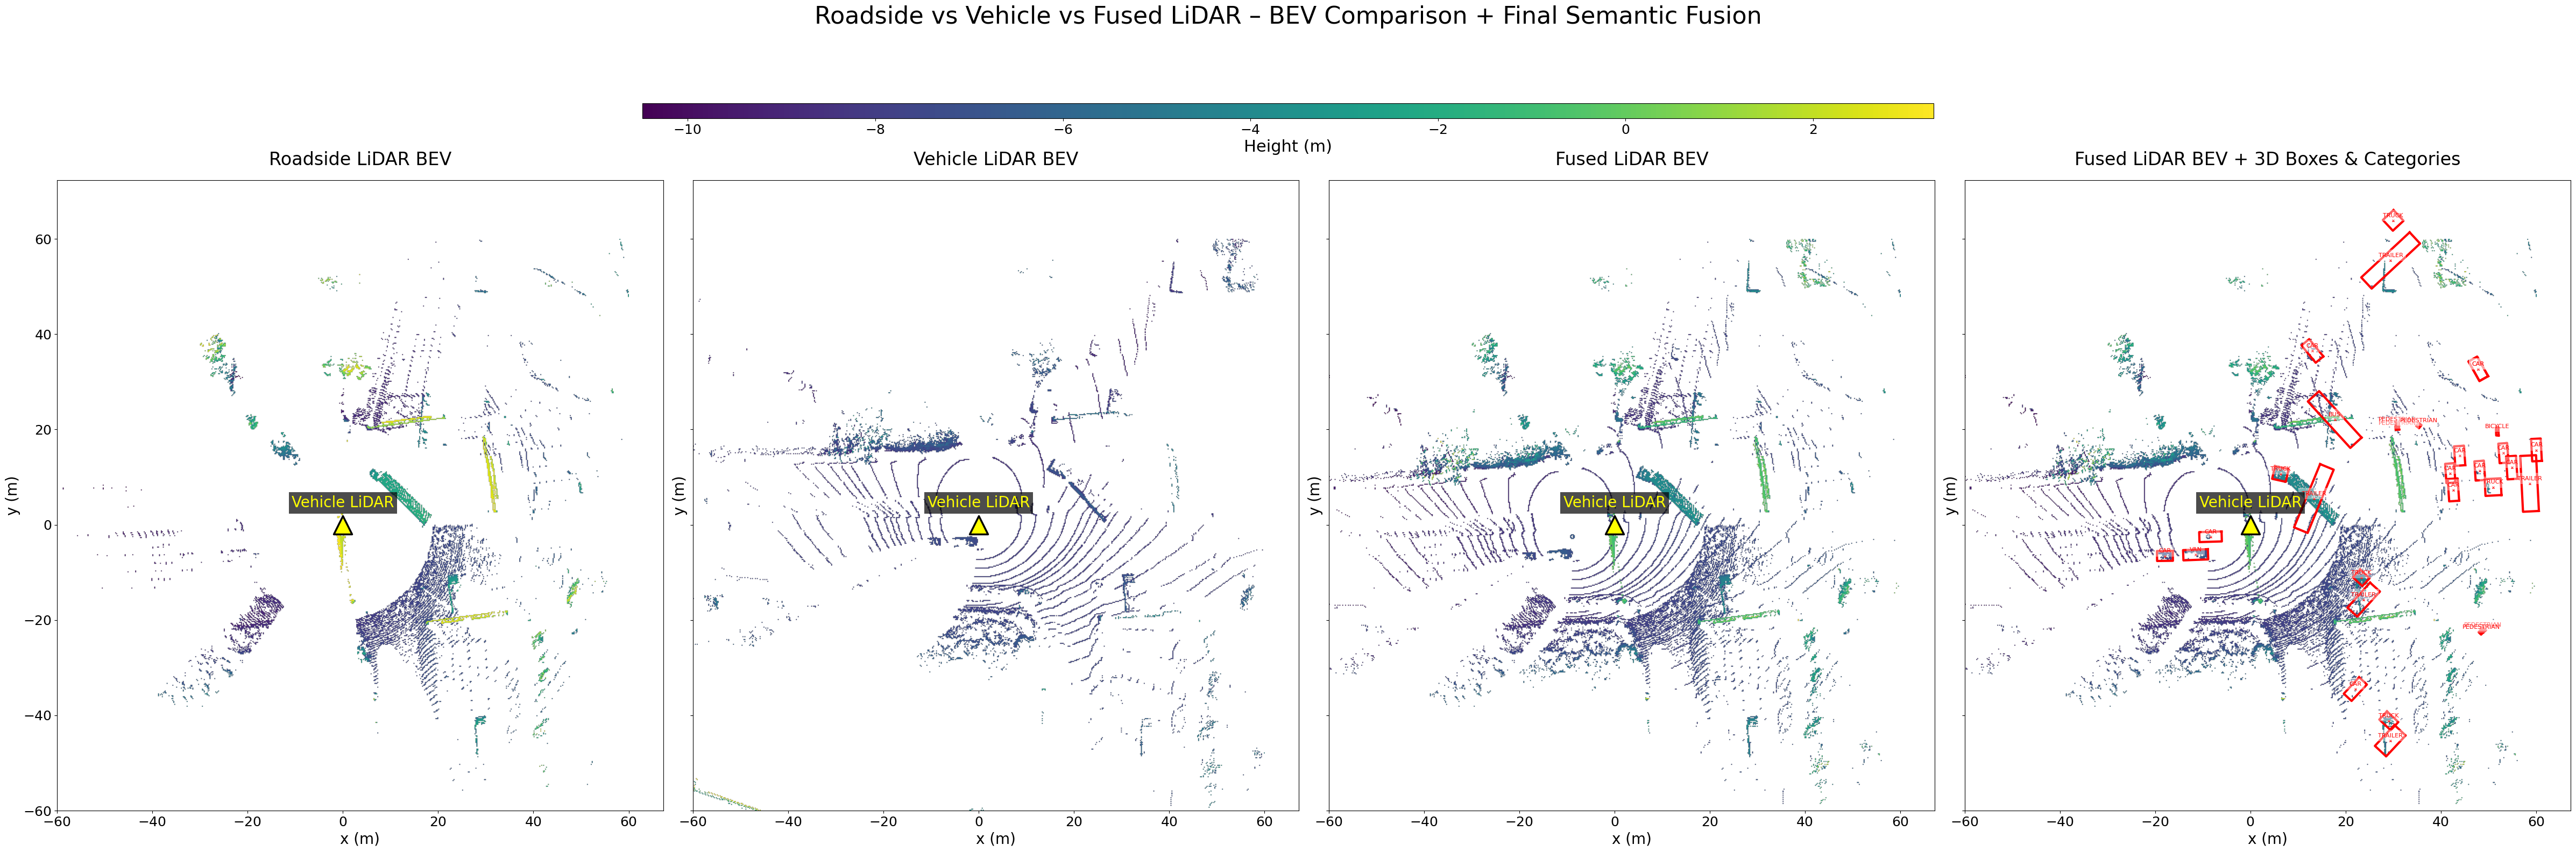

In [40]:
# ==========================================
# HUGE 4-panel comparison with TOP colorbar
# ==========================================

fig, axes = plt.subplots(
    1, 4,
    figsize=(48, 14),        # MUCH bigger panels
    sharex=True,
    sharey=True
)

titles = [
    "Roadside LiDAR BEV",
    "Vehicle LiDAR BEV",
    "Fused LiDAR BEV",
    "Fused LiDAR BEV + 3D Boxes & Categories"
]

bevs = [bev_rs, bev_veh, bev_fused, bev_fused]

# --- Draw each BEV ---
for ax, bev, title in zip(axes, bevs, titles):
    im = ax.imshow(
        bev,
        origin="lower",
        extent=(bev_x_range[0], bev_x_range[1],
                bev_y_range[0], bev_y_range[1])
    )
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel("x (m)", fontsize=20)
    ax.set_ylabel("y (m)", fontsize=20)
    ax.tick_params(labelsize=18)
    ax.set_aspect("equal")

    # ⭐ Mark Vehicle LiDAR location
    ax.scatter(
        VEH_LIDAR_X, VEH_LIDAR_Y,
        marker="^", s=600,
        color="yellow", edgecolor="black", linewidth=2.5,
        zorder=10
    )
    ax.text(
        VEH_LIDAR_X, VEH_LIDAR_Y + 3,
        "Vehicle LiDAR",
        color="yellow",
        fontsize=20,
        ha="center", va="bottom",
        bbox=dict(facecolor="black", alpha=0.7, edgecolor="none"),
        zorder=11
    )

# --- Draw boxes only in the last panel ---
ax_boxes = axes[3]
if boxes:
    draw_boxes_on_bev(
        ax_boxes,
        boxes,
        (bev_x_range[0], bev_x_range[1]),
        (bev_y_range[0], bev_y_range[1]),
        edge_color="red",
        linewidth=3.0,
        show_labels=True
    )

# ==========================================
# HORIZONTAL COLORBAR ABOVE ALL PANELS
# ==========================================

# Create a new axis area ABOVE the entire figure
cbar_ax = fig.add_axes([0.25, 0.93, 0.50, 0.02])   # [left, bottom, width, height]

cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation="horizontal"
)
cbar.set_label("Height (m)", fontsize=22)
cbar.ax.tick_params(labelsize=18)

# ==========================================
# TITLE
# ==========================================

plt.suptitle(
    "Roadside vs Vehicle vs Fused LiDAR – BEV Comparison + Final Semantic Fusion",
    fontsize=32, y=1.08
)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for top colorbar
plt.show()


Camera dir: /content/drive/MyDrive/CoopFusion/train/images/s110_camera_basler_south1_8mm
Camera image files: ['01.jpg']
Using camera image: /content/drive/MyDrive/CoopFusion/train/images/s110_camera_basler_south1_8mm/01.jpg
Camera image shape: (1200, 1920, 3)


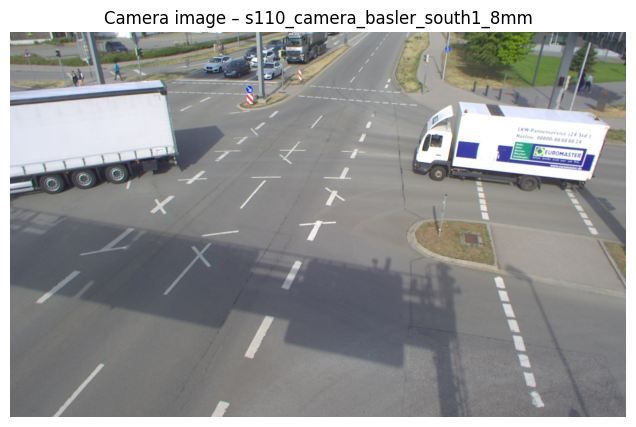

In [46]:
CAM_NAME = "s110_camera_basler_south1_8mm"  # you can change later

CAM_DIR = os.path.join(IMG_DIR, CAM_NAME)
print("Camera dir:", CAM_DIR)

cam_files = [f for f in os.listdir(CAM_DIR)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]
print("Camera image files:", cam_files)

if len(cam_files) == 0:
    raise RuntimeError("No image file found in camera folder.")

cam_img_name = sorted(cam_files)[0]
cam_img_path = os.path.join(CAM_DIR, cam_img_name)
print("Using camera image:", cam_img_path)

img_bgr = cv2.imread(cam_img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError("Failed to read image.")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print("Camera image shape:", img_rgb.shape)

plt.figure(figsize=(8, 5))
plt.imshow(img_rgb)
plt.title(f"Camera image – {CAM_NAME}")
plt.axis("off")
plt.show()


In [47]:
rs_calib_path = os.path.join(CALIB_DIR, "s110_lidar_ouster_south.json")
print("Roadside LiDAR calibration file:", rs_calib_path)

with open(rs_calib_path, "r") as f:
    rs_calib = json.load(f)

print("Calibration keys:", list(rs_calib.keys())[:20])

proj_key = f"projection_matrix_into_{CAM_NAME}"
if proj_key not in rs_calib:
    raise RuntimeError(f"Projection key '{proj_key}' not found in calibration. "
                       f"Available keys: {list(rs_calib.keys())}")

P_raw = rs_calib[proj_key]
P = np.array(P_raw, dtype=np.float32)

if P.shape == (12,):
    P = P.reshape(3, 4)
elif P.shape != (3, 4):
    raise RuntimeError(f"Unexpected projection matrix shape: {P.shape}")

print("Projection matrix P (3x4):\n", P)


Roadside LiDAR calibration file: /content/drive/MyDrive/CoopFusion/calibration/s110_lidar_ouster_south.json
Calibration keys: ['projection_matrix_into_s110_camera_basler_south1_8mm', 'projection_matrix_into_s110_camera_basler_south2_8mm', 'transformation_matrix_s110_lidar_ouster_south_to_s110_base']
Projection matrix P (3x4):
 [[ 7.0421606e+02 -1.3731744e+03 -4.3223578e+02 -2.0336936e+04]
 [-9.2835136e+01 -1.7754393e+01 -1.4562917e+03  9.8029004e+02]
 [ 8.7173599e-01 -9.0345301e-02 -4.8157400e-01 -2.5854599e+00]]


In [48]:
def project_points_to_image(points, P, img_shape,
                            max_points=50000,
                            z_min=0.0, z_max=120.0):
    H, W = img_shape[0], img_shape[1]

    if points.shape[0] > max_points:
        idx = np.random.choice(points.shape[0], max_points, replace=False)
        pts = points[idx]
    else:
        pts = points

    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    pts_h = np.hstack([pts.astype(np.float32), ones])

    proj = (P @ pts_h.T).T
    u = proj[:, 0]
    v = proj[:, 1]
    w = proj[:, 2]

    valid = w > 1e-6
    u = u[valid] / w[valid]
    v = v[valid] / w[valid]
    depths = w[valid]

    mask = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    u = u[mask]
    v = v[mask]
    depths = depths[mask]

    if z_min is not None:
        mask_z = depths >= z_min
        u, v, depths = u[mask_z], v[mask_z], depths[mask_z]
    if z_max is not None:
        mask_z2 = depths <= z_max
        u, v, depths = u[mask_z2], v[mask_z2], depths[mask_z2]

    uvs = np.stack([u, v], axis=1)
    return uvs, depths


Projected fused points in image: 8946


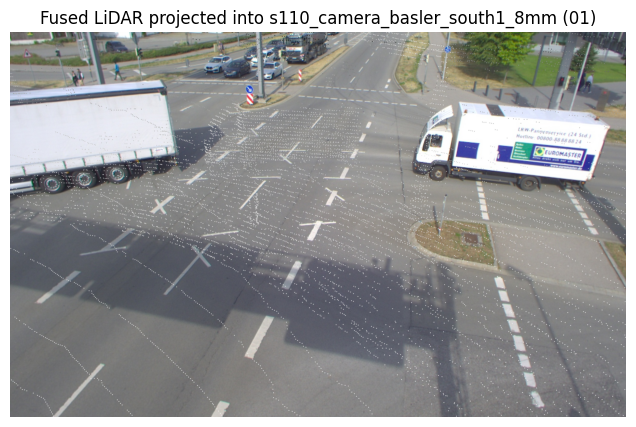

In [49]:
uvs_fused, depths_fused = project_points_to_image(
    fused_points,
    P,
    img_rgb.shape,
    max_points=80000,
    z_min=0.0,
    z_max=120.0
)

print("Projected fused points in image:", uvs_fused.shape[0])

if depths_fused.size > 0:
    d_min_f, d_max_f = depths_fused.min(), depths_fused.max()
    depth_norm_f = (depths_fused - d_min_f) / max(1e-6, (d_max_f - d_min_f))
else:
    depth_norm_f = np.array([])

overlay_fused = img_rgb.copy()

for (u, v), d in zip(uvs_fused.astype(int), depth_norm_f):
    c = int(255 * (1.0 - d))  # nearer = brighter
    cv2.circle(overlay_fused, (u, v), radius=1, color=(c, c, c), thickness=-1)

plt.figure(figsize=(8, 5))
plt.imshow(overlay_fused)
plt.title(f"Fused LiDAR projected into {CAM_NAME} (01)")
plt.axis("off")
plt.show()
